### GPU 메모리 설정

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3024)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

### library loading

In [2]:
import os
import os.path as pth
import json
import shutil
import numpy as np
import pandas as pd
import time
import itertools
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv3D, AveragePooling3D, MaxPooling3D, Dropout, \
                                    Concatenate, GlobalMaxPool3D, GlobalAvgPool3D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import MobileNetV2, ResNet101V2
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy import stats
from PIL import Image 
import cv2
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.utils import shuffle
from itertools import product, combinations
from IPython.display import clear_output
from multiprocessing import Process, Queue
import datetime


### train, val 설정

In [3]:
train_dir = '/home/lab10/data/deepfake/train_new'

# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    classes=['real','fake'], 
    target_size=(299,299), 
    batch_size=20, 
    class_mode='binary', subset='training') 

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    classes=['real','fake'], 
    target_size=(299,299), 
    batch_size=20, 
    class_mode='binary', subset='validation') 

# generator에서 출력된 데이터의 shape확인
for x_data, t_data in train_generator:
    print('x_data shape : ', x_data.shape) # (20,299,299,3)
    print('t_data shape : ', t_data.shape) # (20,)
    break;


Found 304531 images belonging to 2 classes.
Found 76131 images belonging to 2 classes.
x_data shape :  (20, 299, 299, 3)
t_data shape :  (20,)


### parameter 설정!  알맞게 수정해주세요

In [4]:
################ 구분될 수 있도록 모델 이름 적어주세요 ############

BASE_MODEL_NAME = 'ResNet101V2'

########## 데이터 path 잡아주세요 #############

data_base_path = pth.join('data', 'deepfake')
os.makedirs(data_base_path, exist_ok=True)

####### 아래에서 resize, input_shape, batch_size,                    ##########
####### buffer_size, steps_per_epoch, validation_steps, num_epoch  설정해주세요 #########

config = {
    'is_zscore':True,

    'aug': {
        'resize': (299, 299),
    },

    'input_shape': (299, 299, 3),

    'output_activation': 'sigmoid',
    'num_class': 1,
    'output_size': 1,
    
    'conv':{
        'conv_num': (0), # (3,5,3),
        'base_channel': 0, # 4,
        'kernel_size': 0, # 3,
        'padding':'same',
        'stride':'X'
    },
    'pool':{
        'type':'X',
        'size':'X',
        'stride':'X',
        'padding':'same'
    },
    'fc':{
        'fc_num': 0,
     },
    
    'activation':'relu',
    
    'between_type': 'avg',
    
    'is_batchnorm': True,
    'is_dropout': False,
    'dropout_rate': 0.5,
    
    'batch_size': 20,
    'buffer_size': 128,
    'loss': 'binary_crossentropy',
    'steps_per_epoch': 2000, 
    'validation_steps' : 50, 
    'num_epoch': 100,
    'learning_rate': 1e-4,
    
    'random_state': 7777
}

############################ 이하는 건드리지 않기 ####################

conv_comb_list = []
conv_comb_list += [(0,)]

base_channel_list = [0]

fc_list = [0] # 128, 0

# between_type_list = [None, 'avg', 'max']
between_type_list = ['avg']

batch_size_list = [80]

activation_list = ['relu']

# len(conv_comb_list), conv_comb_list

### 모델 디자인

In [5]:
def build_cnn():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(299, 299, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.5))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    return model

### 모델 생성


In [6]:
model = build_cnn()
model.summary()
del model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 35, 35, 128)       0

### 모델 학습 및 모든 epoch 결과 저장

ResNet101V2_resize_299_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O
Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2000/2000 [==============================] - ETA: 0s - loss: 0.2828 - acc: 0.8675 - precision: 0.9054 - recall: 0.7912 - auc: 0.9481
Epoch 00001: saving model to data/deepfake/checkpoint/ResNet101V2_resize_299_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000001-0.139825-0.282823.hdf5
2000/2000 [==============================] - 303s 151ms/step - loss: 0.2828 - acc: 0.8675 - precision: 0.9054 - recall: 0.7912 - auc: 0.9481 - val_loss: 0.1398 - val_acc: 0.9480 - val_precision: 0.9720 - val_recall: 0.9123 - val_auc: 0.9877
Epoch 2/100
2000/2000 [==============================] - ETA: 0s - loss: 0.1051 - acc: 0.9640 - precision: 0.9712 - recall: 0.9486 - auc: 0.9908
Epoch 00002: saving model to data/deepfake/checkpoint/ResNet101V2_resize_299_conv_0_basech_0_act_relu_pool_X_betw_

Epoch 15/100
2000/2000 [==============================] - ETA: 0s - loss: 0.0174 - acc: 0.9943 - precision: 0.9950 - recall: 0.9923 - auc: 0.9995
Epoch 00015: saving model to data/deepfake/checkpoint/ResNet101V2_resize_299_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000015-0.023720-0.017420.hdf5
2000/2000 [==============================] - 438s 219ms/step - loss: 0.0174 - acc: 0.9943 - precision: 0.9950 - recall: 0.9923 - auc: 0.9995 - val_loss: 0.0237 - val_acc: 0.9910 - val_precision: 0.9930 - val_recall: 0.9861 - val_auc: 0.9997
Epoch 00015: early stopping



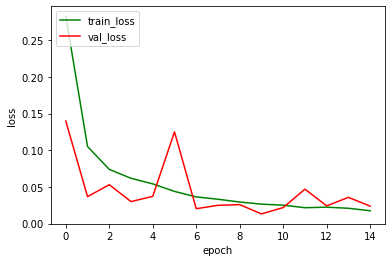

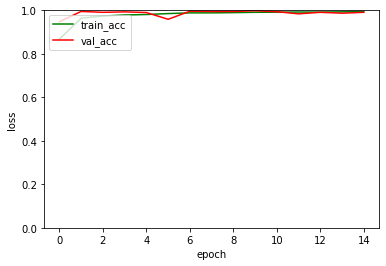

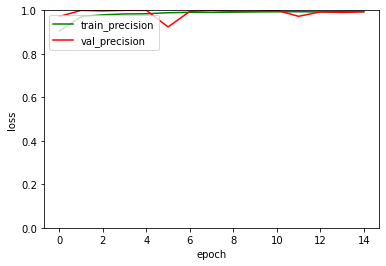

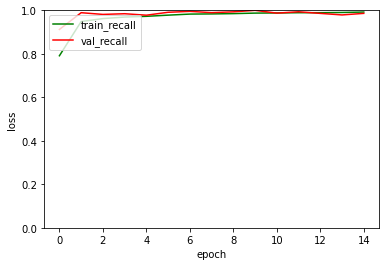

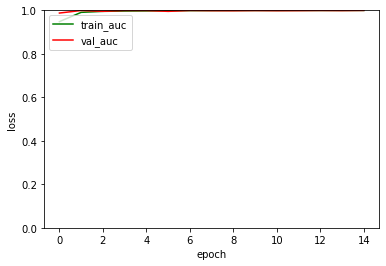

In [7]:
model_base_path = data_base_path
model_checkpoint_path = pth.join(model_base_path, 'checkpoint')

with tf.device('/device:GPU:0'):
    for conv_comb, activation, base_channel, \
        between_type, fc_num, batch_size \
            in itertools.product(conv_comb_list, activation_list,
                                  base_channel_list, between_type_list, fc_list,
                                  batch_size_list):
        config['conv']['conv_num'] = conv_comb
        config['conv']['base_channel'] = base_channel
        config['activation'] = activation
        config['between_type'] = between_type
        config['fc']['fc_num'] = fc_num
        config['batch_size'] = batch_size

        base = BASE_MODEL_NAME

        base += '_resize_{}'.format(config['aug']['resize'][0])

        base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
        base += '_basech_{}'.format(config['conv']['base_channel'])
        base += '_act_{}'.format(config['activation'])
        base += '_pool_{}'.format(config['pool']['type'])
        base += '_betw_{}'.format(config['between_type'])
        base += '_fc_{}'.format(config['fc']['fc_num'])
        base += '_zscore_{}'.format(config['is_zscore'])
        base += '_batch_{}'.format(config['batch_size'])
        if config['is_dropout']:
            base += '_DO_'+str(config['dropout_rate']).replace('.', '')
        if config['is_batchnorm']:
            base += '_BN'+'_O'
        else:
            base += '_BN'+'_X'

        model_name = base
        print(model_name)

        model_path = pth.join(
            model_checkpoint_path, model_name, 
        )
        model = build_cnn()
        #         model.summary()
        model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                      metrics=['acc', 'Precision', 'Recall', 'AUC'])
        initial_epoch = 0

        if pth.isdir(model_path) and len([_ for _ in os.listdir(model_path) if _.endswith('hdf5')]) >= 1:
            model_chk_name = sorted(os.listdir(model_path))[-1]
            initial_epoch = int(model_chk_name.split('-')[0])
            model.load_weights(pth.join(model_path, model_chk_name))

        # ### Freeze first layer
        # conv_list = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv2D)]
        # conv_list[0].trainable = False
        # # conv_list[1].trainable = False

        os.makedirs(model_path, exist_ok=True)
        model_filename = pth.join(model_path, '{epoch:06d}-{val_loss:0.6f}-{loss:0.6f}.hdf5')
        checkpointer = ModelCheckpoint(
            filepath=model_filename, verbose=1, 
            period=1, save_best_only=False, 
            monitor='val_loss'
        )
        es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

        hist = model.fit(
            x=train_generator, epochs=config['num_epoch'], 
            validation_data=validation_generator,
            callbacks = [checkpointer, es], #batch_size=config['batch_size']
            initial_epoch=initial_epoch,
#             steps_per_epoch=train_num_steps, validation_steps=val_num_steps,
            steps_per_epoch=config['steps_per_epoch'], validation_steps=config['validation_steps'],            
            verbose=1,
        )

        model_analysis_path = model_path.replace('checkpoint', 'analysis')
        visualization_path = pth.join(model_analysis_path,'visualization')
        os.makedirs(visualization_path, exist_ok=True)

        print()
        # clear_output()        
        for each_label in ['loss', 'acc', 'precision', 'recall', 'auc']:
            fig, ax = plt.subplots()
            ax.plot(hist.history[each_label], 'g', label='train_{}'.format(each_label))
            ax.plot(hist.history['val_{}'.format(each_label)], 'r', label='val_{}'.format(each_label))
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')
            ax.legend(loc='upper left')
            if not each_label == 'loss':
                plt.ylim(0, 1)
            plt.show()
            filename = 'learning_curve_{}'.format(each_label)
    #             fig.savefig(pth.join(visualization_path, filename), transparent=True)
            plt.cla()
            plt.clf()
            plt.close('all')

        np.savez_compressed(pth.join(visualization_path, 'learning_curve'), 
                            loss=hist.history['loss'], 
                            val_loss=hist.history['val_loss'],
                            acc=hist.history['acc'], 
                            val_acc=hist.history['val_acc'],
                            precision=hist.history['precision'], 
                            vaval_precisionl_mae=hist.history['val_precision'],  
                            recall=hist.history['recall'],
                            val_recall=hist.history['val_recall'],
                            auc=hist.history['auc'],
                            val_auc=hist.history['val_auc']
                            )

        model.save(pth.join(model_path, '000000_last.hdf5'))
        K.clear_session()
        del(model)

        model_analysis_base_path = pth.join(model_base_path, 'analysis', model_name) 
        with open(pth.join(model_analysis_base_path, 'config.json'), 'w') as f:
            json.dump(config, f)

        chk_name_list = sorted([name for name in os.listdir(model_path) if name != '000000_last.hdf5'])
        for chk_name in chk_name_list[:-2]:
            os.remove(pth.join(model_path, chk_name))
        # clear_output()

### Inference ### 이부분은 일단 건너뛰시고 아래 모델비교로 GO!

In [ ]:
image_feature_description_for_test = {
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    # 'randmark_id': tf.io.FixedLenFeature([], tf.int64),
    # 'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function_for_test(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description_for_test)

def map_func_for_test(target_record):
    img = target_record['image_raw']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img

def resize_and_crop_func_for_test(image):
    result_image = tf.image.resize(image, config['aug']['resize'])
    # result_image = tf.image.random_crop(image, size=config['input_shape'], seed=7777)
    return result_image

def post_process_func_for_test(image):
    # result_image = result_image / 255
    result_image = my_model_base.preprocess_input(image)
    return result_image

In [ ]:
submission_base_path = pth.join(data_base_path, 'submission')
os.makedirs(submission_base_path, exist_ok=True)

In [ ]:
for conv_comb, activation, base_channel, \
    between_type, fc_num, batch_size \
        in itertools.product(conv_comb_list, activation_list,
                              base_channel_list, between_type_list, fc_list,
                              batch_size_list):
    config['conv']['conv_num'] = conv_comb
    config['conv']['base_channel'] = base_channel
    config['activation'] = activation
    config['between_type'] = between_type
    config['fc']['fc_num'] = fc_num
    config['batch_size'] = batch_size

    base = BASE_MODEL_NAME

    base += '_resize_{}'.format(config['aug']['resize'][0])

    base += '_conv_{}'.format('-'.join(map(lambda x:str(x),config['conv']['conv_num'])))
    base += '_basech_{}'.format(config['conv']['base_channel'])
    base += '_act_{}'.format(config['activation'])
    base += '_pool_{}'.format(config['pool']['type'])
    base += '_betw_{}'.format(config['between_type'])
    base += '_fc_{}'.format(config['fc']['fc_num'])
    base += '_zscore_{}'.format(config['is_zscore'])
    base += '_batch_{}'.format(config['batch_size'])
    if config['is_dropout']:
        base += '_DO_'+str(config['dropout_rate']).replace('.', '')
    if config['is_batchnorm']:
        base += '_BN'+'_O'
    else:
        base += '_BN'+'_X'

    model_name = base
    print(model_name)

    ### Define dataset
    test_dataset = tf.data.TFRecordDataset(test_tfrecord_path, compression_type='GZIP')
    test_dataset = test_dataset.map(_parse_image_function_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(map_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(resize_and_crop_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(config['batch_size'])
    test_dataset = test_dataset.map(post_process_func_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    model_path = pth.join(
        model_checkpoint_path, model_name, 
    )
    model = build_cnn(config)
    #         model.summary()
    model.compile(loss=config['loss'], optimizer=Adam(lr=config['learning_rate']),
                  metrics=['acc', 'Precision', 'Recall', 'AUC'])
    initial_epoch = 0

    model_chk_name = sorted(os.listdir(model_path))[-1]
    initial_epoch = int(model_chk_name.split('-')[0])
    model.load_weights(pth.join(model_path, model_chk_name))

    preds = model.predict(test_dataset, verbose=1)
    pred_labels = np.argmax(preds, axis=1)
    pred_probs = np.array([pred[indice] for pred, indice in zip(preds, pred_labels)])

    submission_csv_path = pth.join(data_base_path, submission_csv_name)
    submission_df = pd.read_csv(submission_csv_path)

    submission_df['landmark_id'] = pred_labels
    submission_df['conf'] = pred_probs

    today_str = datetime.date.today().strftime('%Y%m%d')
    result_filename = '{}.csv'.format(model_name)
    submission_csv_fileaname = pth.join(submission_base_path, '_'.join([today_str, result_filename]))
    submission_df.to_csv(submission_csv_fileaname, index=False)

## 8등 모델과 각 epoch 결과의 유사도 비교

In [ ]:
#### 앞서 설정한 data_base_path 아래에 checkpoint 폴더아래에 모델명에 맞는 폴더안에 기록된 h5들을 읽어 비교 결과를 도출합니다
#### 각 모델 파일 크기가 크니 최고 유사 모델을 도출하신 후 나머지 모델파일은 삭제해 주세요!

In [13]:
############## 모델 비교 함수 설정 ##############

import pandas as pd
import numpy as np
    
def mk_model_chk_list():
    print('=========== Reading models ===========')
    model_chk_list = []
    model_chk_name_list = sorted(os.listdir(model_path))
    model_chk_name_list = [model_path +'/'+ num for num in model_chk_name_list]
                             
    for model_chk_name in model_chk_name_list:
        model_chk = tf.keras.models.load_model(model_chk_name)
        model_chk_list.append(model_chk) 
                                 
    return model_chk_list                             
                                 
def score(s):
    if s >= 0.5:
        return 1
    else:
        return 0
                                 
def mk_sim_list():
    sim_list = []                             
    model_chk_list = mk_model_chk_list() 
    path_test = '/home/lab22/data/project_deepfake/test/test_600x600/'                             
    df = pd.read_csv('/home/lab10/data/deepfake/sample_submission.csv')                              
    id_list = df.iloc[:,0].values 
    id_list=[path_test + num for num in id_list]
    image_w = 299 
    image_h = 299 
    test_img_arr=[]
    print('=========== Loading images ===========')
    for i, f in tqdm(enumerate(id_list), total=len(id_list)): 
        img = Image.open(f) 
        img = img.convert("RGB") 
        img = img.resize((image_w, image_h)) 
        data = np.asarray(img)
        data = data/255              
        test_img_arr.append(data)  
    test_img_arr = np.array(test_img_arr)
    model_csv = pd.read_csv('/home/lab10/data/deepfake/sample_submission_jin_1111.csv')
    print('=========== Calculating probability ===========')
    for mod_chk in tqdm(model_chk_list, total=len(model_chk_list)):                          
        prob = mod_chk.predict(test_img_arr)
        result = np.array([a for a in map(score, prob)]).ravel()
        dy = model_csv['y']==result
        sim = sum(dy)/len(dy)
        sim_list.append(sim)
    print('=========== Complete ===========')
    max=tf.argmax(sim_list)
    print('최고 유사도: {}'.format(np.max(sim_list)))
    maxidx = sorted(os.listdir(model_path))[max]
    print('file: {}'.format(maxidx))
    return sim_list


=========== Reading models ===========


  0%|          | 9/4100 [00:00<00:50, 80.87it/s]

=========== Loading images ===========


  0%|          | 0/3 [00:00<?, ?it/s]

=========== Calculating probability ===========


100%|██████████| 3/3 [00:59<00:00, 19.91s/it]


=========== Complete ===========
최고 유사도: 0.9478048780487804
file: 000014-0.035679-0.020781.hdf5


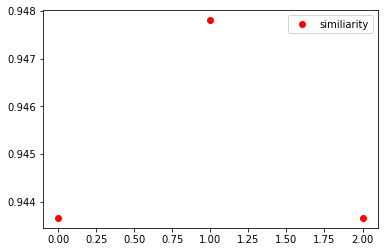

In [14]:
% matplotlib inline

### 최종 비교  결과 실행 ###

result = mk_sim_list()
plt.plot(result, 'bo', color='r', label='similiarity')
plt.legend()
plt.show()

In [15]:
# 기학습 된 모델 불러오기
model = tf.keras.models.load_model('/home/lab03/data/deepfake/checkpoint/ResNet101V2_resize_299_conv_0_basech_0_act_relu_pool_X_betw_avg_fc_0_zscore_True_batch_80_BN_O/000014-0.035679-0.020781.hdf5')

In [16]:

path_test = '/home/lab22/data/project_deepfake/test/test_600x600/'                             
df = pd.read_csv('/home/lab10/data/deepfake/sample_submission.csv')


id_list = df.iloc[:,0].values 
print(len(id_list))

id_list=[path_test + num for num in id_list]

image_w = 299 
image_h = 299 
 
test_img_arr = [] 
prediction=[]
batch_size=20                     
steps=len(id_list)//batch_size
print('-'*70)

def score(s):
    if s >= 0.5:
        return 1
    else:
        return 0
    
# print(prediction)
# detector = MTCNN()

for e in range(steps):
    for i, f in enumerate(id_list[e*batch_size:(e+1)*batch_size]): 
        img = Image.open(f) 
        # print(f)
        # img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
        img = img.convert("RGB") 
        img = img.resize((image_w, image_h)) 
        # print(img.shape)
        data = np.asarray(img)
        data = data/255                # rescale
        test_img_arr.append(data)  

    test_img_arr = np.array(test_img_arr)               
    result = model.predict(test_img_arr)
    pred = [score(s) for s in result]
    prediction.append(pred)    
    test_img_arr = []
    print(f'Step {e+1}/ {steps}', end='\n')
print('-'*70)

4100
----------------------------------------------------------------------
Step 1/ 205
Step 2/ 205
Step 3/ 205
Step 4/ 205
Step 5/ 205
Step 6/ 205
Step 7/ 205
Step 8/ 205
Step 9/ 205
Step 10/ 205
Step 11/ 205
Step 12/ 205
Step 13/ 205
Step 14/ 205
Step 15/ 205
Step 16/ 205
Step 17/ 205
Step 18/ 205
Step 19/ 205
Step 20/ 205
Step 21/ 205
Step 22/ 205
Step 23/ 205
Step 24/ 205
Step 25/ 205
Step 26/ 205
Step 27/ 205
Step 28/ 205
Step 29/ 205
Step 30/ 205
Step 31/ 205
Step 32/ 205
Step 33/ 205
Step 34/ 205
Step 35/ 205
Step 36/ 205
Step 37/ 205
Step 38/ 205
Step 39/ 205
Step 40/ 205
Step 41/ 205
Step 42/ 205
Step 43/ 205
Step 44/ 205
Step 45/ 205
Step 46/ 205
Step 47/ 205
Step 48/ 205
Step 49/ 205
Step 50/ 205
Step 51/ 205
Step 52/ 205
Step 53/ 205
Step 54/ 205
Step 55/ 205
Step 56/ 205
Step 57/ 205
Step 58/ 205
Step 59/ 205
Step 60/ 205
Step 61/ 205
Step 62/ 205
Step 63/ 205
Step 64/ 205
Step 65/ 205
Step 66/ 205
Step 67/ 205
Step 68/ 205
Step 69/ 205
Step 70/ 205
Step 71/ 205
Step 72/ 2

In [17]:
# 제출파일 생성

df = pd.DataFrame({'path': df.iloc[:,0].values, 
                   'y': np.array(prediction).ravel()}, 
                    columns = ['path','y']) 

display(df) 

df.to_csv (r'./data/project_deepfake/sample_submisstion_sampling_1114_ResNet101V2.csv', index = False, header=True) 

,path,y
0,leaderboard/image_00000.jpg,0
1,leaderboard/image_00001.jpg,0
2,leaderboard/image_00002.jpg,0
3,leaderboard/image_00003.jpg,0
4,leaderboard/image_00004.jpg,1
...,...,...
4095,leaderboard/image_04095.jpg,1
4096,leaderboard/image_04096.jpg,0
4097,leaderboard/image_04097.jpg,1
4098,leaderboard/image_04098.jpg,1
